Let's try making our own dataset with pictures of violins and cellos to see if a NN can distinguish between them.

for cellos, our query is:  `cello -electric -sheet`

for violins, our query is: `violin -electric -sheet -vector -color`

# Possible updates! : http://ai.stanford.edu/~bangpeng/ppmi.html

In [2]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

In [3]:
from fastai.vision import *
from fastai.metrics import error_rate

Here we'll define some folders and files for our list of URLs that we got from google.

In [4]:
folder = 'cellos'
file = 'urls_cellos.csv'

In [5]:
folder = 'violins'
file = 'urls_violins.csv'

Run this once per file to create destinations

In [7]:
path = Path('data/instruments')
dest = path/folder
dest.mkdir(parents=True, exist_ok=True)

In [8]:
path.ls()

[PosixPath('data/instruments/models'),
 PosixPath('data/instruments/cellos'),
 PosixPath('data/instruments/cleaned.csv'),
 PosixPath('data/instruments/export.pkl'),
 PosixPath('data/instruments/.ipynb_checkpoints'),
 PosixPath('data/instruments/urls_cellos.csv'),
 PosixPath('data/instruments/urls_violins.csv'),
 PosixPath('data/instruments/test_uploads'),
 PosixPath('data/instruments/violas'),
 PosixPath('data/instruments/violins')]

In [9]:
classes = ['cellos', 'violas']

Also run this in conjunction with the other thing you have to run once per instrument.

In [33]:
download_images(path/file, dest, max_pics=200)

Now we have to verify that these images are openable and delete them if not

This code loops through all classes and verifies all images in each of those class folders.

In [34]:
for c in classes:
    print(c)
    verify_images(path/c, delete=True, max_size=500)

cellos


violas


Now we can create an databunch using this imagenet format, where our directories store the class names

In [35]:
np.random.seed(42)
data = ImageDataBunch.from_folder(path, train=".", valid_pct=0.2,
        ds_tfms=get_transforms(), size=224, num_workers=4).normalize(imagenet_stats)

In [36]:
data.classes

['cellos', 'violins']

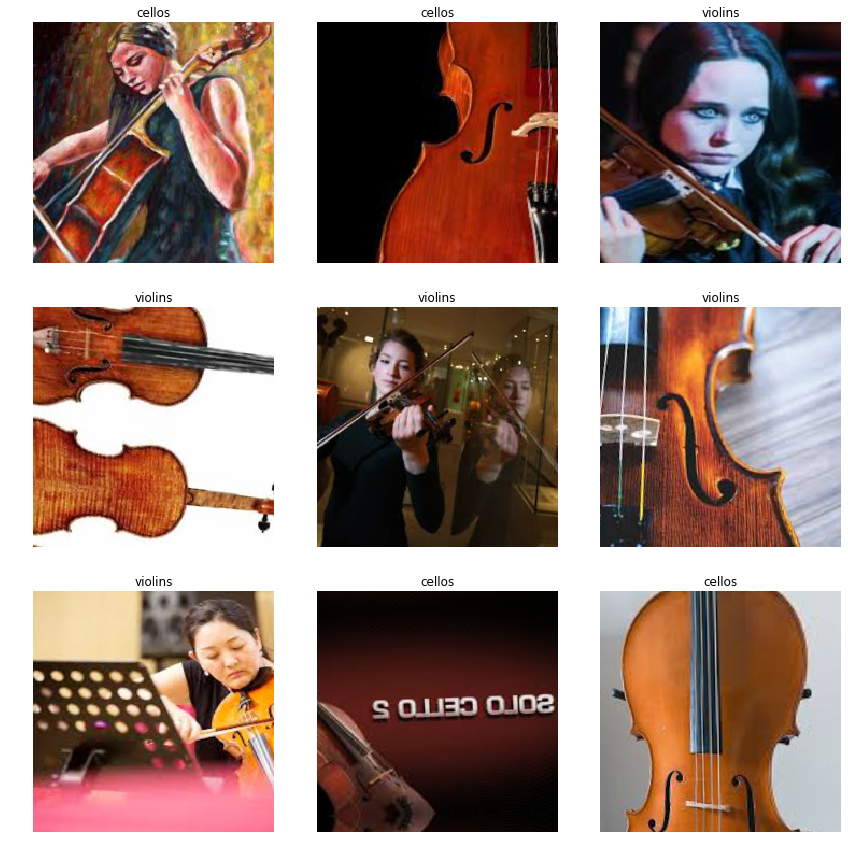

In [38]:
data.show_batch(rows = 3)

We can look at the stats of our dataset (i.e. the classes, # of classes, length of training set, length of val set, ...)

In [39]:
data.classes, data.c, len(data.train_ds), len(data.valid_ds)

(['cellos', 'violins'], 2, 320, 80)

## Training

Now let's use a resnet to actually train a model on the DataBunch

In [40]:
learn = cnn_learner(data, models.resnet34, metrics=error_rate)

In [41]:
learn.fit_one_cycle(4)

epoch,train_loss,valid_loss,error_rate,time
0,1.088064,0.650793,0.275000,00:03
1,0.974519,0.667358,0.225000,00:02
2,0.807888,0.548595,0.212500,00:02
3,0.723876,0.535379,0.212500,00:02


In [43]:
interp = ClassificationInterpretation.from_learner(learn)

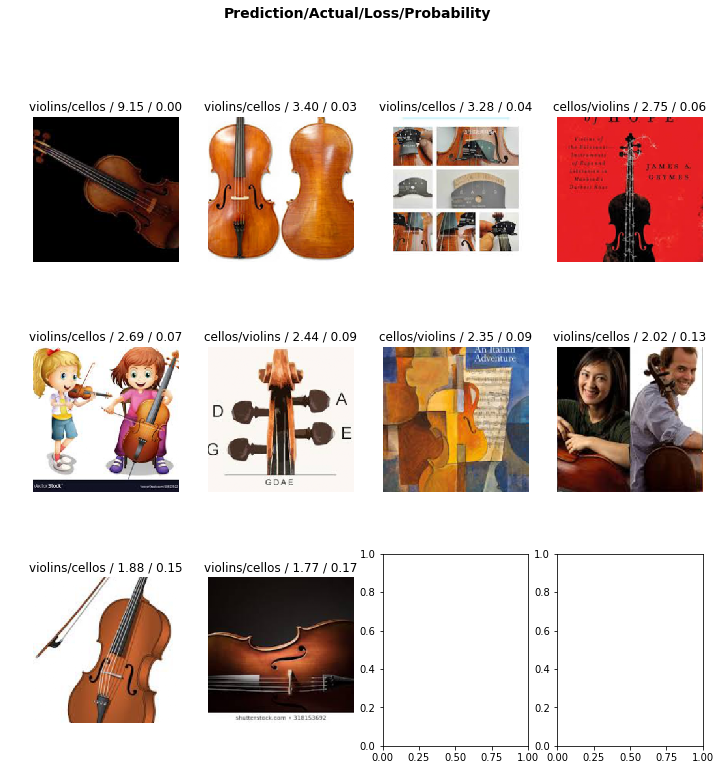

In [44]:
interp.plot_top_losses(10)

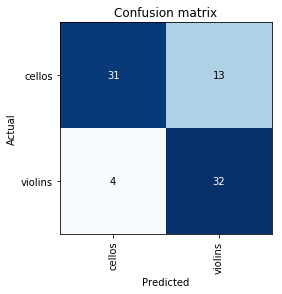

In [45]:
interp.plot_confusion_matrix()

In [47]:
learn.save('stage-1')

In [48]:
learn.unfreeze()

In [49]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


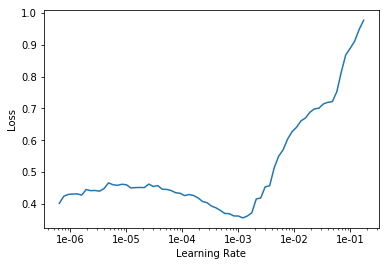

In [50]:
learn.recorder.plot()

In [51]:
learn.fit_one_cycle(4, slice(1e-6, 1e-4))

epoch,train_loss,valid_loss,error_rate,time
0,0.547741,0.512186,0.200000,00:03
1,0.525059,0.478572,0.187500,00:03
2,0.496708,0.461221,0.162500,00:03
3,0.482564,0.462056,0.175000,00:02


In [52]:
learn.save('stage-2')

In [54]:
interp = ClassificationInterpretation.from_learner(learn)

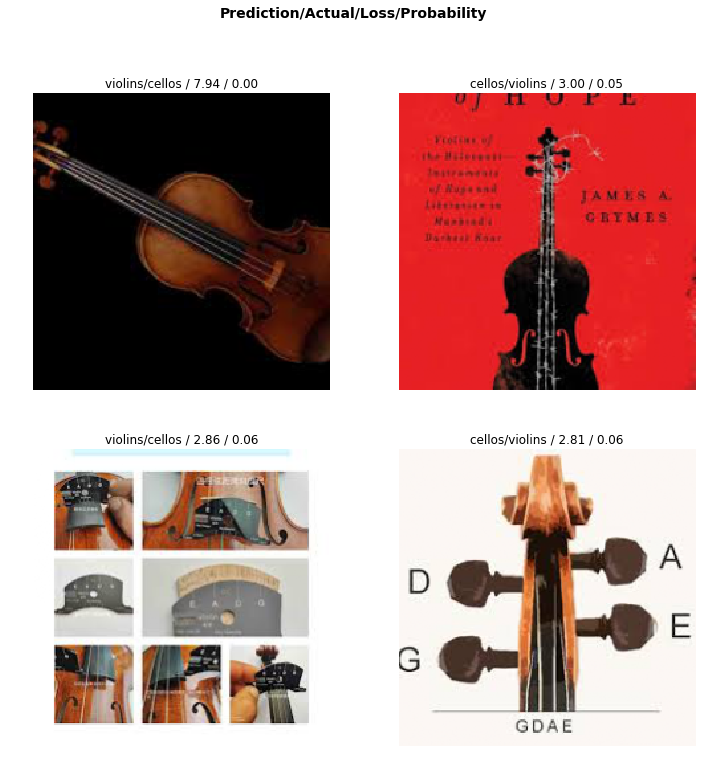

In [56]:
interp.plot_top_losses(4)

## Cleaning

Now let's clean our data! We do this by removing shitty data points

In [18]:
from fastai.widgets import *

This code creates a DataBunch that has no validation set (split_none)

In [19]:
db = (ImageList.from_folder(path)
                   .split_none()
                   .label_from_folder()
                   .transform(get_transforms(), size=224)
                   .databunch()
     )

Now we can make a new learner that is cleaned

In [20]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

#load the weights from before
learn_cln.load('stage-2')

Learner(data=ImageDataBunch;

Train: LabelList (400 items)
x: ImageList
Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224),Image (3, 224, 224)
y: CategoryList
cellos,cellos,cellos,cellos,cellos
Path: data/instruments;

Valid: LabelList (0 items)
x: ImageList

y: CategoryList

Path: data/instruments;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1

In [21]:
ds, idxs = DatasetFormatter().from_toplosses(learn_cln)

In [22]:
ds

LabelList (400 items)
x: ImageList
Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300),Image (3, 250, 300)
y: CategoryList
cellos,cellos,cellos,cellos,cellos
Path: data/instruments

In [23]:
idxs

tensor([140, 181,  92, 208, 258, 241, 126, 178,  96, 240,  78, 125, 156, 302,
         68,  48, 155,  12, 157,  22,  46, 278, 308, 124,  10, 232, 246,  64,
        284, 395,  77, 147, 380, 165, 228, 217, 133,  54,   0, 315, 303, 327,
        253, 236, 247,  59,  34, 306,  27,  57, 117, 382,  62, 301, 287, 330,
        141,  89, 164, 266, 148,  28, 203,  19, 280,  13, 169, 304, 332,  94,
         67, 389, 353,  61, 139,   7, 319,  26,  56, 118, 109, 108, 176,  52,
        229, 339, 175, 138, 199, 298, 116, 230,  97, 177, 122, 273, 245,   8,
         44, 144,  14, 261,   6,  25,  49, 238, 386, 153, 376, 221, 397, 205,
        300,  16,  42, 192, 132, 151, 356, 316,  72, 222, 171,  21,  11, 200,
        318,  81, 267, 354,   5, 189, 161,  20,  73,  29,  74, 335, 296,  82,
         93, 271, 371, 158, 193,  15, 398, 341,  85, 367, 299, 355,  50, 368,
        325,  98,  31,  95, 263,  65, 196, 391, 182, 213, 110, 114, 378, 373,
        185, 292, 352, 206,  84,  75, 188, 320, 248, 379,  76, 1

ImageCleaner gives a GUI that lets you decide whether to keep or remove certain bad data.

In [25]:
ImageCleaner(ds, idxs, path)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In [26]:
ds, idxs = DatasetFormatter().from_similars(learn_cln)

Getting activations...


Computing similarities...


In [28]:
ImageCleaner(ds, idxs, path, duplicates=True)

Button(button_style='primary', description='Next Batch', layout=Layout(width='auto'), style=ButtonStyle())

In this code, we're creating a new databunch from the *cleaned* data that we just made

In [12]:
db = ImageDataBunch.from_csv(path, csv_labels='cleaned.csv', size = 224)

In [40]:
learn_cln = cnn_learner(db, models.resnet34, metrics=error_rate)

In [41]:
learn_cln.fit_one_cycle(8)

epoch,train_loss,valid_loss,error_rate,time
0,1.337632,1.022203,0.387500,00:02
1,1.101834,1.643292,0.387500,00:02
2,0.836957,1.236363,0.337500,00:02
3,0.651246,0.870472,0.262500,00:02
4,0.521682,0.641851,0.187500,00:02
5,0.440989,0.588405,0.200000,00:02
6,0.370394,0.566085,0.225000,00:02
7,0.323817,0.567657,0.212500,00:02


In [42]:
interp = ClassificationInterpretation.from_learner(learn_cln)

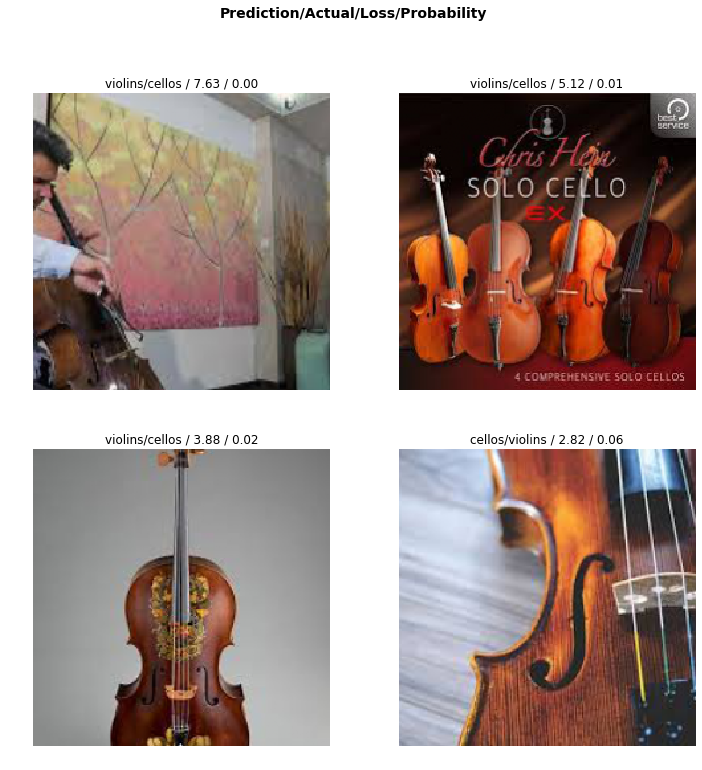

In [43]:
interp.plot_top_losses(4)

In [46]:
learn_cln.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


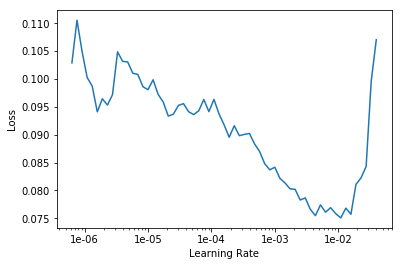

In [48]:
learn_cln.recorder.plot()

In [51]:
learn_cln.fit_one_cycle(4, max_lr=1e-2)

epoch,train_loss,valid_loss,error_rate,time
0,0.072198,1.143846,0.287500,00:02
1,0.094162,0.992251,0.225000,00:02
2,0.116298,1.152451,0.275000,00:02
3,0.122761,1.016744,0.212500,00:02


In [52]:
learn_cln.export()

In [53]:
defaults.device = torch.device('cpu')

Upload image to test_uploads. Tell me the name of image with extension.cell2.png
This is in class cellos
The algorithm guessed:
Probability of cellos is 99.62%
Probability of violins is 0.38%


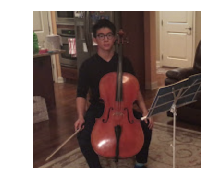

In [67]:
prompt = input("Upload image to test_uploads. Tell me the name of image with extension.")
img = open_image(path/'test_uploads'/prompt)
learn = load_learner(path)
cls, label, probs = learn.predict(img)
img.show()
print("This is in class", db.classes[label.item()])
print("The algorithm guessed:")
for i, prob in enumerate(probs):
    prob = prob.item()
#     print(prob)
    printo = 'Probability of {} is {:.2%}'.format(db.classes[i], prob)
    print(printo)

In [71]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import PIL

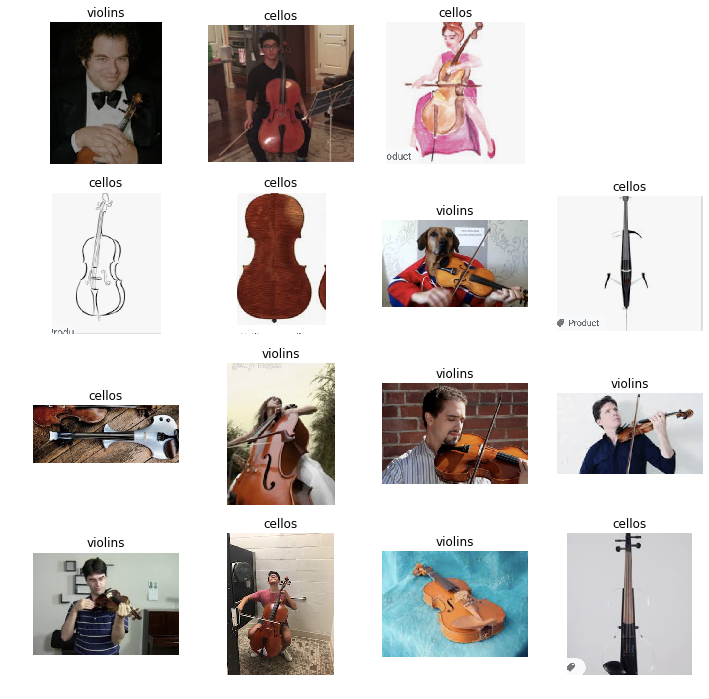

In [101]:
learn = load_learner(path)
# path = data/instruments
filenames = os.listdir(path/'test_uploads')
width = 4
plotDim = width**2
startIndex = 3
fig = plt.figure(figsize=(12,12))
# you can change the slice
for i, name in enumerate(filenames[startIndex : startIndex + plotDim]):
    if name == '.ipynb_checkpoints':
        continue
    imgPath = path/'test_uploads'/name
    img = open_image(imgPath)
    cls, label, probs = learn.predict(img)
    prediction = db.classes[label.item()]
#     print(prediction)
    fig.add_subplot(width, width,i + 1)
    PILimage = PIL.Image.open(imgPath)
    plt.axis('off')
    plt.title(prediction)
    plt.imshow(PILimage)
    
    